In [1]:
!nvidia-smi

Thu Jun 27 16:15:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   72C    P8              19W /  72W |    118MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 0. 라이브러리

In [2]:
import os

# OS 충돌 방지
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Matplotlib 커널 종료 방지
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random
import zipfile
import copy
import glob
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

from torchvision import transforms

import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup

In [4]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 42
fixSEED(seed=seed)

In [5]:
# 디렉토리 설정
dir = 'Python_Programs'
path = '/home/leesanghyuk2000/' + dir
os.chdir(path)
print('Current path: {}'.format(os.getcwd()))

Current path: /home/leesanghyuk2000/Python_Programs


In [6]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1. 데이터 불러오기

In [7]:
# 데이터 불러오기
with open('youtubeData(8331)_with_label.pkl', 'rb') as f:
    data = pickle.load(f)

In [9]:
# 썸네일 이미지가 없는 데이터 있는지 확인
data[data['saved'] == 0]

,youtuber,my_label,channel_id,title,video_id,thumbnail,content,saved,label


In [10]:
# 열 생성
data['drive_saved'] = 0

# 썸네일 파일 경로
thumbnail_path = 'Thumbnails/Thumbnails'

# 각 video_id에 대해 파일 존재 여부 확인
for i in tqdm(data.index, desc="Checking thumbnails"):
    video_id = data.at[i, 'video_id']
    file_path = os.path.join(thumbnail_path, f"{video_id}.jpg")
    if os.path.isfile(file_path):
        data.at[i, 'drive_saved'] = 1

Checking thumbnails: 100%|██████████| 8331/8331 [00:00<00:00, 18152.88it/s]


In [11]:
data['drive_saved'].value_counts()

drive_saved
1    8331
Name: count, dtype: int64

In [12]:
# 레이블 개수 확인
data['label'].value_counts()

label
0    5208
1    3123
Name: count, dtype: int64

### 2. Train/Test/Valid

In [13]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['label'])
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED, stratify = train_val_data['label'])

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [14]:
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 4998개 
검증용 데이터 개수 : 1666개 
평가용 데이터 개수 : 1667개


### 3. Dataset 및 DataLoader 정의

In [15]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [16]:
# LeNet+Transformers Dataset
class LeNetTransformerDataset(Dataset):
    def __init__(self, dataframe, text_tokenizer, max_length, image_path, transform=None):
        self.data = dataframe
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        content = self.data.iloc[idx]['content'] # 내용
        video_id = self.data.iloc[idx]['video_id'] # 영상 ID
        label = self.data.iloc[idx]['label']

        # text 토크나이저
        text_inputs = self.text_tokenizer(content, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        input_ids = text_inputs['input_ids'].squeeze(0)
        attention_mask = text_inputs['attention_mask'].squeeze(0)

        # image 불러오기 및 전처리
        img_path = os.path.join(self.image_path, f"{video_id}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)            

        return input_ids, attention_mask, image, torch.tensor(label, dtype=torch.long)  # 정수형


### 4. 모델 정의

#### 4-1. LeNet

In [17]:
class LeNet(nn.Module):
    def __init__(self, output_dim=768):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7)) # 고정된 크기의 출력, Linear를 사용하면 이미지 크기에 따라 바뀜
        self.fc1 = nn.Linear(32 * 7 * 7, output_dim) # RoBERTa의 출력크기인 768과 맞춰줌
        self.relu3 = nn.ReLU()

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.adaptive_pool(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc1(out)
        out = self.relu3(out)
        return out


#### 4-2. Transformers Encoder
- 참고 : https://github.com/rickiepark/nlp-with-transformers/blob/main/03_transformer-anatomy.ipynb

In [18]:
# Scaled Dot-Product Attention
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

# Attention Head
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs
    
# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

# Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x
    
# Embeddings
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids):
        # 입력 시퀀스에 대해 위치 ID를 만듭니다.
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device).unsqueeze(0)
        # 토큰 임베딩과 위치 임베딩을 만듭니다.
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # 토큰 임베딩과 위치 임베딩을 합칩니다.
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

# Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # 층 정규화를 적용하고 입력을 쿼리, 키, 값으로 복사합니다.
        hidden_state = self.layer_norm_1(x)
        # 어텐션에 스킵 연결을 적용합니다.
        x = x + self.attention(hidden_state)
        # 스킵 연결과 피드 포워드 층을 적용합니다.
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x
    
# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config)
                                     for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

#### 4-3. Attention Mechanism

In [19]:
# Attention Mechanism
class AttentionMechanism(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionMechanism, self).__init__()
        self.attention = nn.Linear(input_dim, hidden_dim)
        self.context_vector = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, features):
        # features: (batch_size, seq_len, input_dim)
        attention_weights = torch.tanh(self.attention(features))
        attention_weights = self.context_vector(attention_weights).squeeze(-1)
        attention_weights = F.softmax(attention_weights, dim=1)
        context_vector = torch.sum(features * attention_weights.unsqueeze(-1), dim=1)
        return context_vector, attention_weights

#### 4-4. LeNet + Transformers Model

In [20]:
class LeNetTransformerModel(nn.Module):
    def __init__(self, text_config, lenet_model):
        super(LeNetTransformerModel, self).__init__()

        # Use Transformer Encoder for text
        self.text_model = TransformerEncoder(text_config)

        # Use LeNet for image
        self.img_model = lenet_model

        # Attention Mechanism
        self.attention = AttentionMechanism(text_config.hidden_size + 768, 512)

        # Classifier layer
        self.classifier = nn.Linear(text_config.hidden_size + 768, 2)

        # Dropout
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_ids, attention_mask, images):
        # Text model forward
        text_hidden_state = self.text_model(input_ids)

        # Image model forward
        img_hidden_state = self.img_model(images)

        # Concat text and image result
        concat_hidden_state = torch.cat((text_hidden_state[:, 0, :], img_hidden_state), dim=1)

        # Apply attention mechanism
        context_vector, attention_weights = self.attention(concat_hidden_state.unsqueeze(1))

        # Apply dropout
        context_vector = self.dropout(context_vector)

        # Pass through classifier
        logits = self.classifier(context_vector)

        return logits

### 5. 학습용 Trainer 정의

In [21]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, precision_metric, recall_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.precision_metric = precision_metric  # precision metric
        self.recall_metric = recall_metric  # recall metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience
        
        # 스케줄러 초기화
        total_steps = len(train_dataloader) * num_epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    def train(self):
        train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history = [], [], [], [], []
        valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = [], [], [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 80)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 80)

            train_loss, train_acc, train_precision, train_recall, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_precision_history.append(train_precision)
            train_recall_history.append(train_recall)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_precision_history.append(valid_precision)
            valid_recall_history.append(valid_recall)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t Precision: {train_precision:.4f} \t Recall: {train_recall:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t Precision: {valid_precision:.4f} \t Recall: {valid_recall:.4f} \t F1: {valid_f1:.4f}')
            print(f'(Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s)')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    save_path = f'./YouTube_Transformers_LeNet_ACC_{valid_acc:.4f}.pth'
                    torch.save(self.model.state_dict(), save_path)
                    print(f'Model Saved to {save_path}')
                except:
                    print('Model Not Saved')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'Early Stopping at Epoch {epoch+1}')
                    break

        return train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, attention_mask, images, y = batch
            input_ids, attention_mask, images, y = input_ids.to(self.device), attention_mask.to(self.device), images.to(self.device), y.to(self.device)

            outputs = self.model(input_ids, attention_mask, images)
            loss = self.criterion(outputs, y) # 데이터셋에서 레이블을 long으로 정의함

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()  # 스케줄러 업데이트

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_precision += self.precision_metric(preds, y).item()
            train_recall += self.recall_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_precision / len(self.train_dataloader), train_recall / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_precision = 0
        valid_recall = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, attention_mask, images, y = batch
                input_ids, attention_mask, images, y = input_ids.to(self.device), attention_mask.to(self.device), images.to(self.device), y.to(self.device)

                outputs = self.model(input_ids, attention_mask, images)
                loss = self.criterion(outputs, y)

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_precision += self.precision_metric(preds, y).item()
                valid_recall += self.recall_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_precision / len(self.valid_dataloader), valid_recall / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)


### 6. 학습 설정

In [22]:
# 데이터셋 파라미터
batch_size = 32
num_labels = 2
max_length = 64

# text 토크나이저 정의
text_checkpoint = "klue/roberta-small"
tokenizer = AutoTokenizer.from_pretrained(text_checkpoint)

# image 경로
image_path = 'Thumbnails/Thumbnails'

In [23]:
# 이미지 전처리 객체
transform = transforms.Compose(
    [
        transforms.Resize([256, 256]), # 이미지를 크기를 조정
        #transforms.RandomCrop([224, 224]), # 이미지를 랜덤하게 자르기
        #transforms.RandomResizedCrop(256), # 이미지를 랜덤한 크기로 자르고 크기를 조정
        transforms.RandomHorizontalFlip(), # 이미지를 랜덤하게 수평으로 뒤집기
        transforms.RandomVerticalFlip(), # 이미지를 랜덤하게 수직으로 뒤집기
        #transforms.RandomRotation(45), # 이미지를 랜덤하게 회전
        transforms.ToTensor(), # 이미지를 텐서로 변환
        #transforms.Grayscale(num_output_channels=1), # 이미지를 흑백으로 변환
        #transforms.Normalize((0.5,), (0.5,)), # 이미지를 정규화(ToTensor 다음에 사용)
        #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1) # 이미지의 밝기, 대비, 채도, 색상을 무작위로 조정
])

In [24]:
# 데이터셋 정의
train_dataset = LeNetTransformerDataset(train_data, tokenizer, max_length, image_path, transform)
valid_dataset = LeNetTransformerDataset(valid_data, tokenizer, max_length, image_path, transform)
test_dataset = LeNetTransformerDataset(test_data, tokenizer, max_length, image_path, transform)

In [25]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[    0, 17240,  2052,  ...,  1415,  4000,     2],
         [    0,  4988,  5891,  ...,  2145,  6667,     2],
         [    0,  3909,  2016,  ...,  2259,  3706,     2],
         ...,
         [    0,  5443, 30692,  ...,  2062,  5326,     2],
         [    0, 16465,  2747,  ..., 15154,  2219,     2],
         [    0,   752,  3851,  ...,  1292,  2052,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([[[[0.0235, 0.0235, 0.0235,  ..., 0.0549, 0.0549, 0.0549],
           [0.0235, 0.0235, 0.0235,  ..., 0.0549, 0.0549, 0.0549],
           [0.0235, 0.0235, 0.0235,  ..., 0.0549, 0.0549, 0.0549],
           ...,
           [0.0235, 0.0235, 0.0235,  ..., 0.0902, 0.0980, 0.1059],
           [0.0235, 0.0235, 0.0235,  ..., 0.0941, 0.0824, 0.0745],
           [0.0235, 0.0235, 0.0235,  ..., 0.0667, 0.0

### 7. 학습 설정

In [26]:
# Transformers 설정
text_config = AutoConfig.from_pretrained(text_checkpoint)

In [27]:
# LeNet 모델 설정
lenet_model = LeNet(output_dim=text_config.hidden_size)
lenet_model

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc1): Linear(in_features=1568, out_features=768, bias=True)
  (relu3): ReLU()
)

In [28]:
# Model
model = LeNetTransformerModel(text_config, lenet_model)
model.to(device)

LeNetTransformerModel(
  (text_model): TransformerEncoder(
    (embeddings): Embeddings(
      (token_embeddings): Embedding(32000, 768)
      (position_embeddings): Embedding(514, 768)
      (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (layer_norm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layer_norm_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attention): MultiHeadAttention(
          (heads): ModuleList(
            (0-11): 12 x AttentionHead(
              (q): Linear(in_features=768, out_features=64, bias=True)
              (k): Linear(in_features=768, out_features=64, bias=True)
              (v): Linear(in_features=768, out_features=64, bias=True)
            )
          )
          (output_linear): Linear(in_features=768, out_features=768, bias=True)
        )
        (feed_forward)

In [29]:
# LoRA 적용 후 훈련 가능한 파라미터 개수
print_trainable_parameters(model)

Trainable Params: 69509090 
All params: 69509090
--------------------------------------------------
Trainable(%): 100.0


In [30]:
# 손실함수와 옵티마이저, 그리고 Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)

In [31]:
# 학습 시작 전 GPU 메모리 확인
def checkGPU(empty=False):
    if torch.cuda.is_available():
        total_mem = torch.cuda.get_device_properties(0).total_memory
        current_mem = torch.cuda.memory_allocated(0)
        free_mem = total_mem - current_mem
        
        print(f'남은 GPU 메모리: {free_mem / (1024 ** 3):.2f} GB')
        
        if empty:
            torch.cuda.empty_cache()
            after_mem = torch.cuda.memory_allocated(0)
            print(f'GPU 캐시에서 메모리 삭제 후 메모리: {after_mem / (1024 ** 3):.2f} GB')
    else:
        print('CUDA 사용 불가')

checkGPU()

남은 GPU 메모리: 21.70 GB


In [32]:
# 모델 학습 파라미터
num_epochs = 3
wait_for_es = 5

In [33]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  precision_metric,
                  recall_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [34]:
# 학습 시작
train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = trainer.train()

--------------------------------------------------------------------------------
Epoch 1/3
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:19<00:00,  2.78it/s]


[Train] 	 Loss: 0.5213 	 Acc: 0.7369 	 Precision: 0.6247 	 Recall: 0.5758 	 F1: 0.5477
[Valid] 	 Loss: 0.3207 	 Acc: 0.8715 	 Precision: 0.8148 	 Recall: 0.8316 	 F1: 0.8183
(Epoch 1 complete in 1m 42s)
Model Saved to ./YouTube_Transformers_LeNet_ACC_0.8715.pth
--------------------------------------------------------------------------------
Epoch 2/3
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:19<00:00,  2.77it/s]


[Train] 	 Loss: 0.3050 	 Acc: 0.8747 	 Precision: 0.8621 	 Recall: 0.8123 	 F1: 0.8221
[Valid] 	 Loss: 0.2675 	 Acc: 0.8903 	 Precision: 0.8809 	 Recall: 0.7706 	 F1: 0.8153
(Epoch 2 complete in 3m 27s)
Model Saved to ./YouTube_Transformers_LeNet_ACC_0.8903.pth
--------------------------------------------------------------------------------
Epoch 3/3
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:19<00:00,  2.71it/s]


[Train] 	 Loss: 0.2369 	 Acc: 0.9102 	 Precision: 0.9042 	 Recall: 0.8559 	 F1: 0.8735
[Valid] 	 Loss: 0.2492 	 Acc: 0.9004 	 Precision: 0.8790 	 Recall: 0.8449 	 F1: 0.8571
(Epoch 3 complete in 5m 10s)
Model Saved to ./YouTube_Transformers_LeNet_ACC_0.9004.pth


In [35]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history):
    plt.figure(figsize=(16, 9))

    # Loss Plot
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
    ax1.plot(train_loss_history, label='Train Loss')
    ax1.plot(valid_loss_history, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2 = plt.subplot2grid((2, 4), (1, 0))
    ax2.plot(train_acc_history, label='Train Accuracy')
    ax2.plot(valid_acc_history, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Precision Plot
    ax3 = plt.subplot2grid((2, 4), (1, 1))
    ax3.plot(train_precision_history, label='Train Precision')
    ax3.plot(valid_precision_history, label='Validation Precision')
    ax3.set_title('Training and Validation Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend()

    # Recall Plot
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax4.plot(train_recall_history, label='Train Recall')
    ax4.plot(valid_recall_history, label='Validation Recall')
    ax4.set_title('Training and Validation Recall')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Recall')
    ax4.legend()

    # F1 Plot
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    ax5.plot(train_f1_history, label='Train F1 Score')
    ax5.plot(valid_f1_history, label='Validation F1 Score')
    ax5.set_title('Training and Validation F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend()

    plt.tight_layout()
    plt.show()

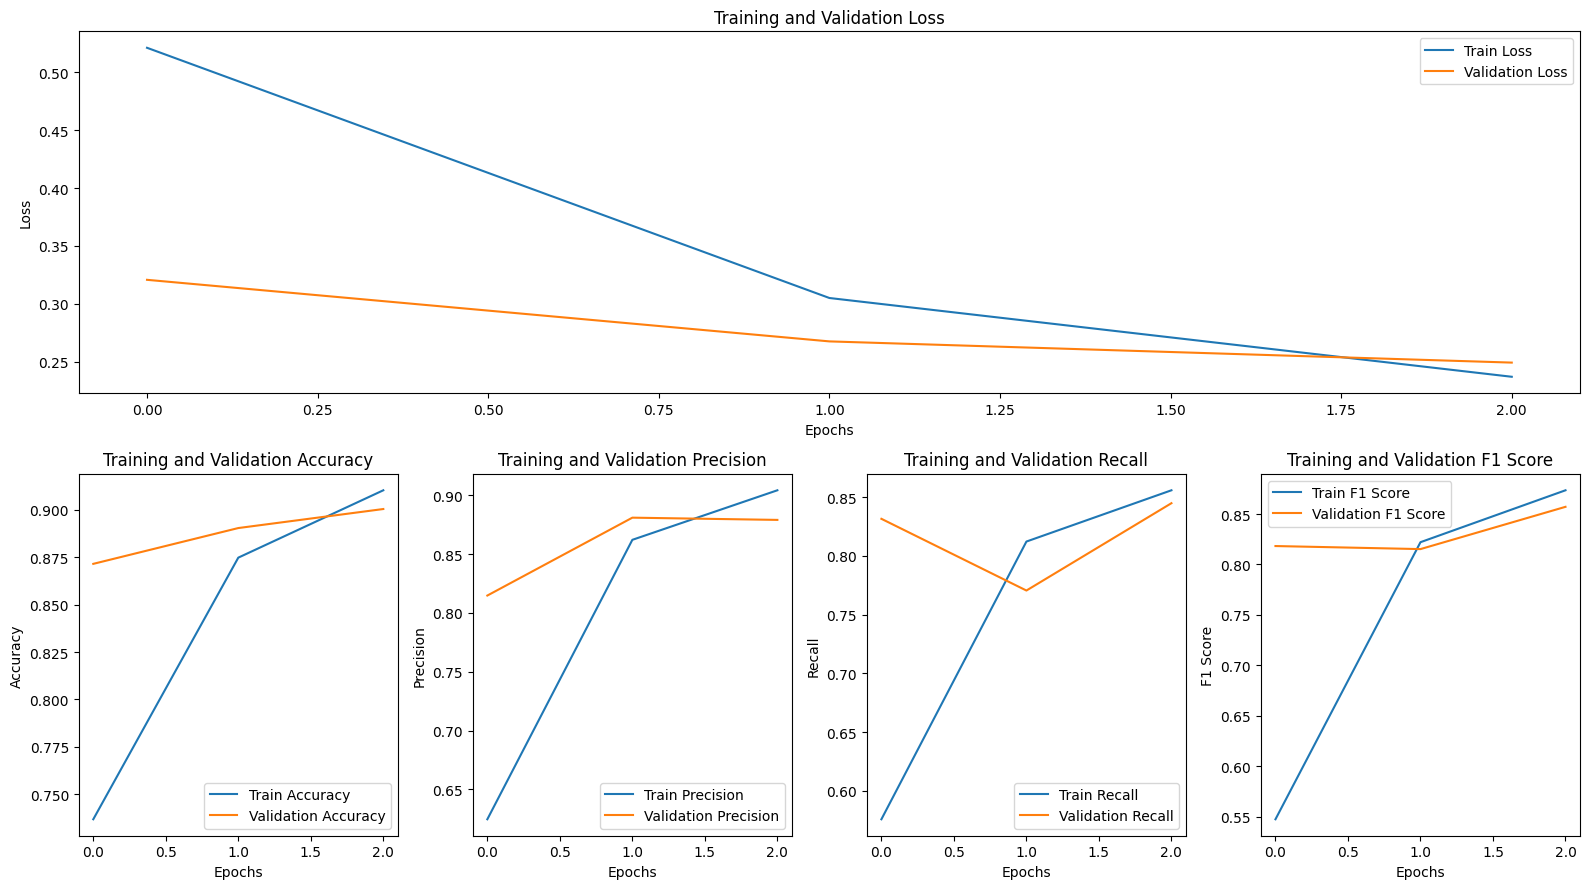

In [36]:
plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history)

### 8. 평가

In [40]:
# 모델 로드 함수 정의
def load_model(model_path, text_config, lenet_model):
    model = LeNetTransformerModel(text_config, lenet_model)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

# Inference 함수 정의
def inference(model, test_dataloader, device):
    model.eval()

    preds_list = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Testing'):
            input_ids, attention_mask, images, labels = batch
            input_ids, attention_mask, images, labels = input_ids.to(device), attention_mask.to(device), images.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask, images)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return preds_list, true_labels

In [41]:
# 저장된 모델 경로
best_model_path = path+'/YouTube_Transformers_LeNet_ACC_0.9004.pth'

In [42]:
# 모델 불러오기
model = load_model(best_model_path, text_config, lenet_model)

In [43]:
preds_list, true_labels = inference(model, test_dataloader, device)

Testing: 100%|██████████| 53/53 [00:22<00:00,  2.37it/s]


In [44]:
# 평가 지표 계산
test_accuracy = accuracy_score(true_labels, preds_list)
test_precision = precision_score(true_labels, preds_list)
test_recall = recall_score(true_labels, preds_list)
test_f1 = f1_score(true_labels, preds_list)
test_cm = confusion_matrix(true_labels, preds_list)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Confusion Matrix: \n{test_cm}')

Test Accuracy: 0.9040
Test Precision: 0.8793
Test Recall: 0.8624
Test F1 Score: 0.8708
Test Confusion Matrix: 
[[968  74]
 [ 86 539]]
